# Import packages and datasets

In [1]:
import pandas as pd
import glob
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [2]:
# Dateset before pandemic
bf_files = glob.glob("Before/*.csv")
bf_li = []

for filename in bf_files:
    df = pd.read_csv(filename, index_col = None, header = 0)
    bf_li.append(df)

bf_data = pd.concat(bf_li, axis = 0, ignore_index = True).sort_values('Start date')

In [3]:
bf_data.head() 

Duration           Start date             End date  \
337552       230  2019-01-01 00:04:48  2019-01-01 00:08:39   
337553      1549  2019-01-01 00:06:37  2019-01-01 00:32:27   
337554       177  2019-01-01 00:08:46  2019-01-01 00:11:44   
337555       228  2019-01-01 00:08:47  2019-01-01 00:12:35   
337556      1300  2019-01-01 00:12:29  2019-01-01 00:34:10   

        Start station number                  Start station  \
337552                 31203     14th & Rhode Island Ave NW   
337553                 31321  15th St & Constitution Ave NW   
337554                 31104    Adams Mill & Columbia Rd NW   
337555                 31281                  8th & O St NW   
337556                 31014           Lynn & 19th St North   

        End station number                                        End station  \
337552               31200               Massachusetts Ave & Dupont Circle NW   
337553               31114                           18th St & Wyoming Ave NW   
337554               31323  Woodley Park Metro / Calvert St & Connecticut ...   
337555               31280                                     11th & S St NW   
337556               31923                        Columbia Pike & S Taylor St   

       Bike number Member type  
337552      E00141      Member  
337553      W24067      Casual  
337554      W22654      Casual  
337555      W22336      Member  
337556       70004      Member

In [4]:
bf_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3935817 entries, 337552 to 1011086
Data columns (total 9 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Duration              int64 
 1   Start date            object
 2   End date              object
 3   Start station number  int64 
 4   Start station         object
 5   End station number    int64 
 6   End station           object
 7   Bike number           object
 8   Member type           object
dtypes: int64(3), object(6)
memory usage: 300.3+ MB


In [5]:
# Dateset after pandemic
af_files = glob.glob("After/*.csv")
af_li = []

for filename in af_files:
    df = pd.read_csv(filename, index_col = None, header = 0)
    af_li.append(df)

af_data = pd.concat(af_li, axis = 0, ignore_index = True).sort_values('started_at')

/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
af_data.head()

ride_id rideable_type           started_at  \
158144  DDF4F5BCEE8D4DA1   docked_bike  2020-05-01 00:02:02   
138266  BAFB16BE2EC822A5   docked_bike  2020-05-01 00:03:34   
185868  B333B92511C7363F   docked_bike  2020-05-01 00:21:01   
186872  B4BD5B9BBAEC4B45   docked_bike  2020-05-01 00:21:09   
156411  9C26104CDECAD6E4   docked_bike  2020-05-01 00:30:26   

                   ended_at              start_station_name start_station_id  \
158144  2020-05-01 00:04:10                   Thomas Circle            31241   
138266  2020-05-01 00:16:04   25th St & Pennsylvania Ave NW            31237   
185868  2020-05-01 00:38:10  Connecticut Ave & Tilden St NW            31313   
186872  2020-05-01 00:54:57   25th St & Pennsylvania Ave NW            31237   
156411  2020-05-01 00:36:08   2nd St & Massachusetts Ave NE            31641   

                      end_station_name end_station_id  start_lat  start_lng  \
158144  17th St & Massachusetts Ave NW        31267.0  38.905900 -77.032500   
138266             16th & Irving St NW        31122.0  38.903827 -77.053485   
185868        Calvert & Biltmore St NW        31106.0  38.941139 -77.061977   
186872       Wilson Blvd & N Quincy St        31039.0  38.903827 -77.053485   
156411                   1st & M St NE        31603.0  38.894972 -77.003135   

          end_lat    end_lng member_casual  
158144  38.908142 -77.038359        member  
138266  38.928893 -77.036250        member  
185868  38.923203 -77.047637        member  
186872  38.880012 -77.107854        casual  
156411  38.905700 -77.005600        member

In [7]:
af_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169546 entries, 158144 to 1226649
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 231.7+ MB


# Preprocessing
1. The dataset before the pandemic only have street-level address, each station address will need to be geocoded by matching them with the existing ones
2. For those cannot match the existing ones, apply geocoding to them
3. Merge two datasets 

In [8]:
# Find unique stations in dataset before the pandemic to reduce the duplicate matcing work
unique_station = set(bf_data['Start station'].tolist() + bf_data['End station'].tolist())

In [9]:
bf_station = pd.DataFrame(unique_station)

In [10]:
bf_station = bf_station.rename(columns = {0: 'station_name'})
bf_station

station_name
0                        Potomac & M St NW
1                   Shady Grove Metro East
2       Towers Crescent Dr & Tysons One Pl
3            22nd St & Constitution Ave NW
4                     Van Ness Metro / UDC
..                                     ...
651           Arlington Blvd & Fillmore St
652      Rhode Island Ave & Montana Ave NE
653              Reservoir Rd & 38th St NW
654            Commonwealth & E Monroe Ave
655  TJ Cmty Ctr / 2nd St & S Old Glebe Rd

[656 rows x 1 columns]

In [11]:
# Find stations in dataset after the pandemic with corresponding latitude and longitude
start_station = af_data[['start_station_name', 'start_lat', 'start_lng']].rename(columns = {'start_station_name': 'station_name', 
                                                                                            'start_lat': 'lat', 
                                                                                            'start_lng': 'lng'})
end_station = af_data[['end_station_name', 'end_lat', 'end_lng']].rename(columns = {'end_station_name': 'station_name', 
                                                                                    'end_lat': 'lat', 
                                                                                    'end_lng': 'lng'})
station_cmb = pd.concat([start_station, end_station], ignore_index = True)

In [12]:
station_cmb = station_cmb.dropna()

In [13]:
# Remove outliers that are definitely not within the scope of the designated bikeshare stations
station_move_outliers = station_cmb[(station_cmb['lat'] > 38.5) & (station_cmb['lng'] > -77.5)]

In [14]:
# Since each bike with its own GPS will generate different location in a station, but they are not much different, 
# so choose the first one in each station
af_station = station_move_outliers.groupby('station_name').first().reset_index()

In [15]:
af_station.head(10)

station_name        lat        lng
0                 10th & E St NW  38.895914 -77.026064
1          10th & Florida Ave NW  38.920387 -77.025672
2                 10th & G St NW  38.898243 -77.026235
3                 10th & K St NW  38.902400 -77.026220
4            10th & Monroe St NE  38.932514 -76.992889
5                 10th & U St NW  38.917200 -77.025900
6  10th St & Constitution Ave NW  38.893028 -77.026013
7    10th St & L'Enfant Plaza SW  38.884323 -77.026010
8                 11th & C St SE  38.885908 -76.991476
9                 11th & F St NW  38.897857 -77.026975

In [16]:
# Explore stations(extra stations) without existing latitude and longitude
station = bf_station.merge(af_station, on = ['station_name'])
extra_sta = bf_station[~bf_station.station_name.isin(station.station_name)].reset_index(drop = True)
extra_sta

station_name
0        Rosedale Rec Center / 17th & Gales St NE
1                McKinley St & Connecticut Ave NW
2   Silver Spring Metro/Colesville Rd & Wayne Ave
3                          28th St S & S Meade St
4                    S Oakland St & Columbia Pike
..                                            ...
68                     Franklin & S Washington St
69                                 19th & L St NW
70                       New Jersey Ave & L St NW
71              Rhode Island Ave & Montana Ave NE
72                    Commonwealth & E Monroe Ave

[73 rows x 1 columns]

In [17]:
# Geocode extra stations
geolocator = Nominatim(user_agent = "myGeocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 1)

In [18]:
extra_sta['station_loc'] = extra_sta['station_name'].apply(geocode)
extra_sta['station_point'] = extra_sta['station_loc'].apply(lambda loc: tuple(loc.point) if loc else None)
extra_sta[['lat', 'lng', 'alt']] = pd.DataFrame(extra_sta['station_point'].tolist(), index = extra_sta.index)

In [19]:
extra_station = extra_sta.dropna()

In [20]:
extra_station_rem = extra_station[(extra_station['lat'] < 39.3) & (extra_station['lng'] < -76.5)]
extra_station_rem

station_name  \
0            Rosedale Rec Center / 17th & Gales St NE   
1                    McKinley St & Connecticut Ave NW   
2       Silver Spring Metro/Colesville Rd & Wayne Ave   
4                        S Oakland St & Columbia Pike   
5                                 N Veitch & Key Blvd   
6                               Grand Park & Rose Ave   
8                                Madison & Fairfax St   
9   Columbia Pike & S Dinwiddie St / Arlington Mil...   
10                               Dennis & Amherst Ave   
11                                     Bethesda Metro   
12                              S Troy St & 26th St S   
16                                Taft St & E Gude Dr   
18        15th St & Pennsylvania Ave NW/Pershing Park   
19                                    18th & Eads St.   
21                              N Veitch  & 20th St N   
22                             Spring St & Second Ave   
23              Wheaton Metro/Georgia Ave & Reedie Dr   
24                                  Royal & Wilkes St   
25  Friendship Hts Metro/Wisconsin Ave & Wisconsin...   
26         Aurora Hills Community Ctr/18th & Hayes St   
27                          Blueridge Ave & Elkins St   
29                        Nebraska Ave/AU East Campus   
30                                     14th & U St NW   
31                          Wilson Blvd & Franklin Rd   
32                               Lynn & 19th St North   
33                   S Four Mile Run & Walter Reed Dr   
34                              S Glebe & Potomac Ave   
35  Shirlington Transit Center / S Quincy & Randol...   
36           37th & Ely Pl SE / Fort Dupont Ice Arena   
37                          Long Bridge Dr & 6th St S   
39                               N Rhodes & 16th St N   
40                            21st St N & N Pierce St   
41          Central Library / N Quincy St & 10th St N   
43     Virginia Square Metro / N Monroe St & 9th St N   
44                                  15th & N Scott St   
46            Pentagon City Metro / 12th & S Hayes St   
47               Ballston Metro / N Stuart & 9th St N   
48                           N Pershing Dr & Wayne St   
50                         N Randolph St & Fairfax Dr   
51                       Pershing & N George Mason Dr   
53  Washington Adventist U / Flower Ave & Division St   
56              Court House Metro / 15th & N Uhle St    
57                  S George Mason Dr & Four Mile Run   
59                                S Joyce & 16th St S   
60                Crystal City Metro / 18th & Bell St   
61       Montgomery College/W Campus Dr & Mannakee St   
62                                   Eads & 22nd St S   
63              S Four Mile Run Dr & S Shirlington Rd   
65                               Utah St & 11th St N    
66                                12th & Army Navy Dr   
67                        S Walter Reed Dr & 8th St S   
68                         Franklin & S Washington St   
69                                     19th & L St NW   
70                           New Jersey Ave & L St NW   

                                          station_loc  \
0   (Rosedale Rec Center / 17th and Gales St NE, 1...   
1   (McKinley St and Connecticut Ave NW, Connectic...   
2   (Silver Spring Metro/Colesville Rd and Wayne A...   
4   (S Oakland St and Columbia Pike, South Oakland...   
5   (N Veitch and Key Blvd, North Veitch Street, C...   
6   (Grand Park and Rose Ave, Grand Park Avenue, M...   
8   (Madison and Fairfax St, Madison Street, Jeffe...   
9   (Columbia Pike and S Dinwiddie St / Arlington ...   
10  (Dennis and Amherst Ave, Dennis Avenue, Carrol...   
11  (Bethesda Metro, Old Georgetown Road, Arlingto...   
12  (S Troy St and 26th St S, 26th Street South, A...   
16  (Taft St and E Gude Dr, Taft Street, Beantown,...   
18  (15th St and Pennsylvania Ave NW/Pershing Park...   
19  (18th and Eads St., 18th Street South, Pentago...   
21  (N Veitch and 20th St N, 21st Street North, Hi

In [21]:
# Total stations with latitude and longitude
total_station = pd.concat([af_station, extra_station_rem[['station_name', 'lat', 'lng']]], ignore_index = True)

In [23]:
# Merge the station dataset into the dataset before the pandemic
bf_data_addstartloc = pd.merge(bf_data, total_station, left_on = 'Start station', right_on = 'station_name', how = 'left')
bf_data_addendloc = pd.merge(bf_data_addstartloc, total_station, left_on = 'End station', right_on = 'station_name', how = 'left', suffixes = ('_start', '_end'))
bf_data_addendloc.head()

Duration           Start date             End date  Start station number  \
0       230  2019-01-01 00:04:48  2019-01-01 00:08:39                 31203   
1      1549  2019-01-01 00:06:37  2019-01-01 00:32:27                 31321   
2       177  2019-01-01 00:08:46  2019-01-01 00:11:44                 31104   
3       228  2019-01-01 00:08:47  2019-01-01 00:12:35                 31281   
4      1300  2019-01-01 00:12:29  2019-01-01 00:34:10                 31014   

                   Start station  End station number  \
0     14th & Rhode Island Ave NW               31200   
1  15th St & Constitution Ave NW               31114   
2    Adams Mill & Columbia Rd NW               31323   
3                  8th & O St NW               31280   
4           Lynn & 19th St North               31923   

                                         End station Bike number Member type  \
0               Massachusetts Ave & Dupont Circle NW      E00141      Member   
1                           18th St & Wyoming Ave NW      W24067      Casual   
2  Woodley Park Metro / Calvert St & Connecticut ...      W22654      Casual   
3                                     11th & S St NW      W22336      Member   
4                        Columbia Pike & S Taylor St       70004      Member   

              station_name_start  lat_start  lng_start  \
0     14th & Rhode Island Ave NW  38.908600 -77.032300   
1  15th St & Constitution Ave NW  38.892244 -77.033234   
2    Adams Mill & Columbia Rd NW  38.922925 -77.042581   
3                  8th & O St NW  38.908640 -77.022770   
4           Lynn & 19th St North  38.897315 -77.070993   

                                    station_name_end    lat_end    lng_end  
0               Massachusetts Ave & Dupont Circle NW  38.910100 -77.044400  
1                           18th St & Wyoming Ave NW  38.918809 -77.041571  
2  Woodley Park Metro / Calvert St & Connecticut ...  38.923389 -77.051833  
3                                     11th & S St NW  38.913761 -77.027025  
4                        Columbia Pike & S Taylor St  38.858524 -77.103728

In [24]:
# Rename columns' names 
bf_data_addloc = bf_data_addendloc.rename(columns = {"Start date": "started_at",
                                                     "End date": "ended_at", 
                                                     "Start station number": "start_station_id",
                                                     "Start station": "start_station_name",
                                                     "End station number": "end_station_id",
                                                     "End station": "end_station_name",
                                                     "lat_start": "start_lat",
                                                     "lng_start": "start_lng",
                                                     "lat_end": "end_lat",
                                                     "lng_end": "end_lng",
                                                     "Member type": "member_casual"})

In [25]:
# Select common columns
column = ["started_at", "ended_at", "start_station_id", "start_station_name","end_station_id",
          "end_station_name", "start_lat", "start_lng", "end_lat", "end_lng", "member_casual"]
bf_filter = bf_data_addloc[column]
af_filter = af_data[column]

In [26]:
# Concate two datasets into a complete dataset
total_data = pd.concat([bf_filter, af_filter], axis = 0, ignore_index = True)
total_data.head()

started_at             ended_at start_station_id  \
0  2019-01-01 00:04:48  2019-01-01 00:08:39            31203   
1  2019-01-01 00:06:37  2019-01-01 00:32:27            31321   
2  2019-01-01 00:08:46  2019-01-01 00:11:44            31104   
3  2019-01-01 00:08:47  2019-01-01 00:12:35            31281   
4  2019-01-01 00:12:29  2019-01-01 00:34:10            31014   

              start_station_name end_station_id  \
0     14th & Rhode Island Ave NW          31200   
1  15th St & Constitution Ave NW          31114   
2    Adams Mill & Columbia Rd NW          31323   
3                  8th & O St NW          31280   
4           Lynn & 19th St North          31923   

                                    end_station_name  start_lat  start_lng  \
0               Massachusetts Ave & Dupont Circle NW  38.908600 -77.032300   
1                           18th St & Wyoming Ave NW  38.892244 -77.033234   
2  Woodley Park Metro / Calvert St & Connecticut ...  38.922925 -77.042581   
3                                     11th & S St NW  38.908640 -77.022770   
4                        Columbia Pike & S Taylor St  38.897315 -77.070993   

     end_lat    end_lng member_casual  
0  38.910100 -77.044400        Member  
1  38.918809 -77.041571        Casual  
2  38.923389 -77.051833        Casual  
3  38.913761 -77.027025        Member  
4  38.858524 -77.103728        Member

In [27]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6105363 entries, 0 to 6105362
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   started_at          object 
 1   ended_at            object 
 2   start_station_id    object 
 3   start_station_name  object 
 4   end_station_id      object 
 5   end_station_name    object 
 6   start_lat           float64
 7   start_lng           float64
 8   end_lat             float64
 9   end_lng             float64
 10  member_casual       object 
dtypes: float64(4), object(7)
memory usage: 512.4+ MB


In [28]:
total_data.isnull().sum()

started_at                 0
ended_at                   0
start_station_id      138604
start_station_name    138604
end_station_id        157000
end_station_name      157000
start_lat               4242
start_lng               4242
end_lat                11185
end_lng                11185
member_casual              0
dtype: int64

In [29]:
data = total_data.dropna()
data.reset_index(inplace = True)

In [30]:
# Change station id and time type
data['start_station_id'] = data['start_station_id'].astype(int)
data['end_station_id'] = data['end_station_id'].astype(int)

<ipython-input-30-e259c86e4e54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['start_station_id'] = data['start_station_id'].astype(int)
<ipython-input-30-e259c86e4e54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['end_station_id'] = data['end_station_id'].astype(int)


In [31]:
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

<ipython-input-31-d9e1c486abea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['started_at'] = pd.to_datetime(data['started_at'])
<ipython-input-31-d9e1c486abea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ended_at'] = pd.to_datetime(data['ended_at'])


In [32]:
# Create trip duration column
data['duration'] = data['ended_at'] - data['started_at']
data['duration'] = data['duration'].dt.total_seconds()

<ipython-input-32-3e9e2e50deba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duration'] = data['ended_at'] - data['started_at']
<ipython-input-32-3e9e2e50deba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duration'] = data['duration'].dt.total_seconds()


In [33]:
# Create month and year column
data['month'] = data['started_at'].dt.month
data['year'] = data['started_at'].dt.year

<ipython-input-33-8267ec704035>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['started_at'].dt.month
<ipython-input-33-8267ec704035>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['started_at'].dt.year


In [34]:
data['member_casual'] =  data['member_casual'].str.capitalize()

<ipython-input-34-5c4fb5edc988>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['member_casual'] =  data['member_casual'].str.capitalize()


In [35]:
data.head()

index          started_at            ended_at  start_station_id  \
0      0 2019-01-01 00:04:48 2019-01-01 00:08:39             31203   
1      1 2019-01-01 00:06:37 2019-01-01 00:32:27             31321   
2      2 2019-01-01 00:08:46 2019-01-01 00:11:44             31104   
3      3 2019-01-01 00:08:47 2019-01-01 00:12:35             31281   
4      4 2019-01-01 00:12:29 2019-01-01 00:34:10             31014   

              start_station_name  end_station_id  \
0     14th & Rhode Island Ave NW           31200   
1  15th St & Constitution Ave NW           31114   
2    Adams Mill & Columbia Rd NW           31323   
3                  8th & O St NW           31280   
4           Lynn & 19th St North           31923   

                                    end_station_name  start_lat  start_lng  \
0               Massachusetts Ave & Dupont Circle NW  38.908600 -77.032300   
1                           18th St & Wyoming Ave NW  38.892244 -77.033234   
2  Woodley Park Metro / Calvert St & Connecticut ...  38.922925 -77.042581   
3                                     11th & S St NW  38.908640 -77.022770   
4                        Columbia Pike & S Taylor St  38.897315 -77.070993   

     end_lat    end_lng member_casual  duration  month  year  
0  38.910100 -77.044400        Member     231.0      1  2019  
1  38.918809 -77.041571        Casual    1550.0      1  2019  
2  38.923389 -77.051833        Casual     178.0      1  2019  
3  38.913761 -77.027025        Member     228.0      1  2019  
4  38.858524 -77.103728        Member    1301.0      1  2019

In [36]:
data.shape

(5890063, 15)

In [37]:
# Create and save dataframs into csv files on March for each year for visualization
data_Mar2019 = data[(data.year == 2019) & (data.month == 3)]
data_Mar2020 = data[(data.year == 2020) & (data.month == 3)]
data_Mar2021 = data[(data.year == 2021) & (data.month == 3)]

In [38]:
data_Mar2019.to_csv(r'data_Mar2019.csv', index = False)
data_Mar2020.to_csv(r'data_Mar2020.csv', index = False)
data_Mar2021.to_csv(r'data_Mar2021.csv', index = False)

## Monthly Ridership

In [39]:
# Aggregate ride counts by year and month
ride_counts = data.groupby(['year', 'month']).size()
ride_counts.unstack()

month        1         2         3         4         5         6         7   \
year                                                                          
2019   148131.0  155214.0  253686.0  347816.0  337500.0  349797.0  356169.0   
2020   196382.0  177901.0  162530.0       NaN  148441.0  213053.0  221567.0   
2021    85219.0   65289.0  148833.0  186864.0       NaN       NaN       NaN   

month        8         9         10        11        12  
year                                                     
2019   359837.0  359965.0  337409.0  223512.0  161878.0  
2020   227488.0  220116.0  202426.0  153132.0   89908.0  
2021        NaN       NaN       NaN       NaN       NaN

In [40]:
# Convert year and month from indexes to columns, rename values columns as ridecount
ride_counts = ride_counts.reset_index(level = ['year', 'month'])
ride_counts.rename(columns = {0: 'ride_count'}, inplace = True)

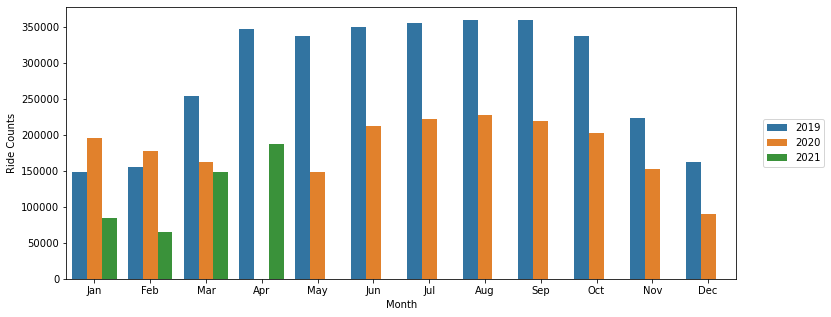

In [41]:
plt.figure(figsize = (12, 5))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax = sns.barplot(x = 'month', y = 'ride_count', data = ride_counts, hue = 'year')
ax.legend(bbox_to_anchor = (1.04, 0.5), loc = 'center left', borderaxespad = 0)
ax.set_xlabel('Month') 
ax.set_ylabel('Ride Counts') 
ax.set_xticklabels(months)
plt.show()

## Ridership by Member Type


In [42]:
# Aggregrate by year, month and member type
member_counts = data.groupby(['year', 'month', 'member_casual']).size().unstack()

In [43]:
member_counts

member_casual  Casual  Member
year month                   
2019 1          11040  137091
     2          12772  142442
     3          37149  216537
     4          61829  285987
     5          51605  285895
     6          54732  295065
     7          54442  301727
     8          51253  308584
     9          42955  317010
     10         34496  302913
     11         17053  206459
     12         11039  150839
2020 1          10618  185764
     2          10662  167239
     3          16607  145923
     5          75163   73278
     6         115677   97376
     7         113049  108518
     8         111320  116168
     9          98684  121432
     10         83788  118638
     11         61598   91534
     12         28780   61128
2021 1          26859   58360
     2          18641   46648
     3          63235   85598
     4          84273  102591

In [44]:
# Create member_percent and casual_percent as percentage of total
member_counts['member_percent'] = member_counts.Member / (member_counts.Member + member_counts.Casual) * 100
member_counts['casual_percent'] = member_counts.Casual / (member_counts.Member + member_counts.Casual) * 100

In [45]:
member_counts = member_counts.reset_index(level = ['year', 'month'])

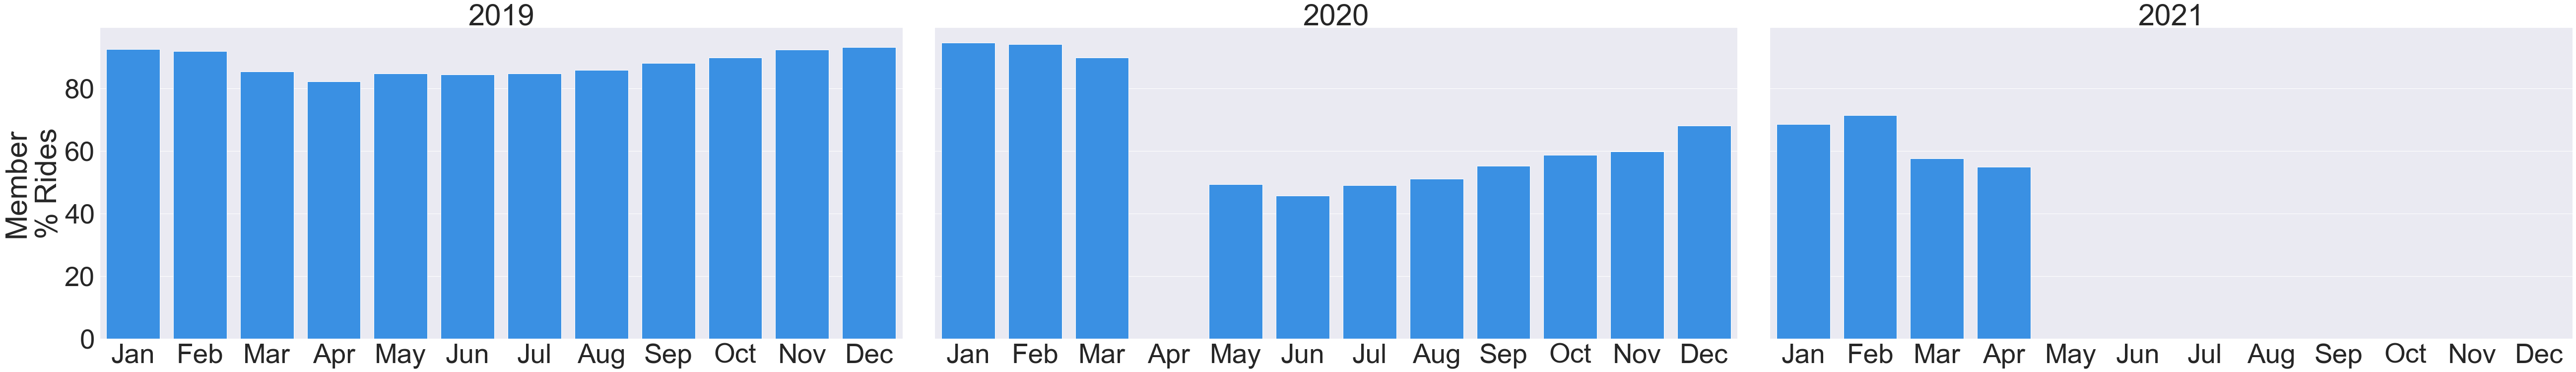

In [46]:
# Use catplot to show separate charts for each year
sns.set(font_scale = 5)
ax = sns.catplot(x = 'month', y = 'member_percent', data = member_counts, col = 'year', 
                 dodge = False, color = 'dodgerblue', kind = 'bar', height = 12, aspect = 20/10 ) 
ax.set_axis_labels('', 'Member\n% Rides')
ax.set_xticklabels(months)
ax.set_titles('{col_name}')

## Trip Duration

In [47]:
median_duration = pd.DataFrame(data[data['duration'] >= 0].groupby(['year', 'month'])['duration'].median())

In [48]:
# Convert seconds to minutes (keeping decimal portion)
median_duration.duration /= 60
median_duration.unstack().round(2)

duration                                                                 \
month       1      2      3      4      5      6      7      8      9      10   
year                                                                            
2019      9.13   9.62  11.12  12.57  12.07  12.30  12.22  11.93  11.58  11.12   
2020      9.58   9.62  12.22    NaN  19.68  17.92  15.45  15.23  14.43  13.53   
2021     11.35  10.62  13.72  13.93    NaN    NaN    NaN    NaN    NaN    NaN   

                     
month     11     12  
year                 
2019    9.93   9.52  
2020   13.40  11.38  
2021     NaN    NaN

In [49]:
median_duration.reset_index(level = ['year', 'month'], inplace = True)

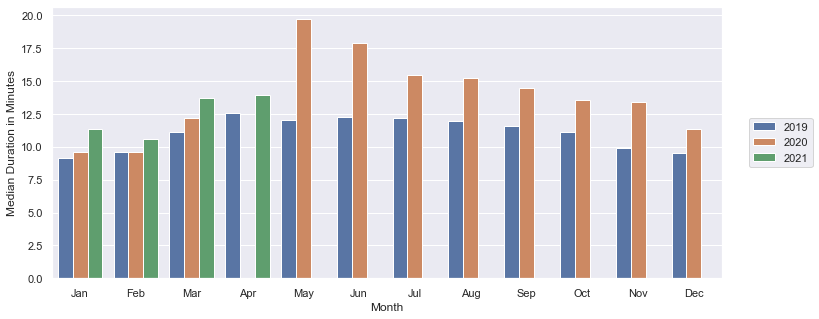

In [50]:
sns.set(font_scale = 1)
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'month', y = 'duration', data = median_duration, hue = 'year')
ax.legend(bbox_to_anchor = (1.04, 0.5), loc = 'center left', borderaxespad = 0)
ax.set_xlabel('Month') 
ax.set_ylabel('Median Duration in Minutes') 
ax.set_xticklabels(months)
plt.show()

## Dynamic Visuals With Kepler
Kepler is an open source web-app developed by Uber to visualize ride-sharing demand within cities over hours, days, months, and years. This allows them to rapidly gain insights into user behavior, communicate with outside entitites such as investors and governments, and forecast future demand.

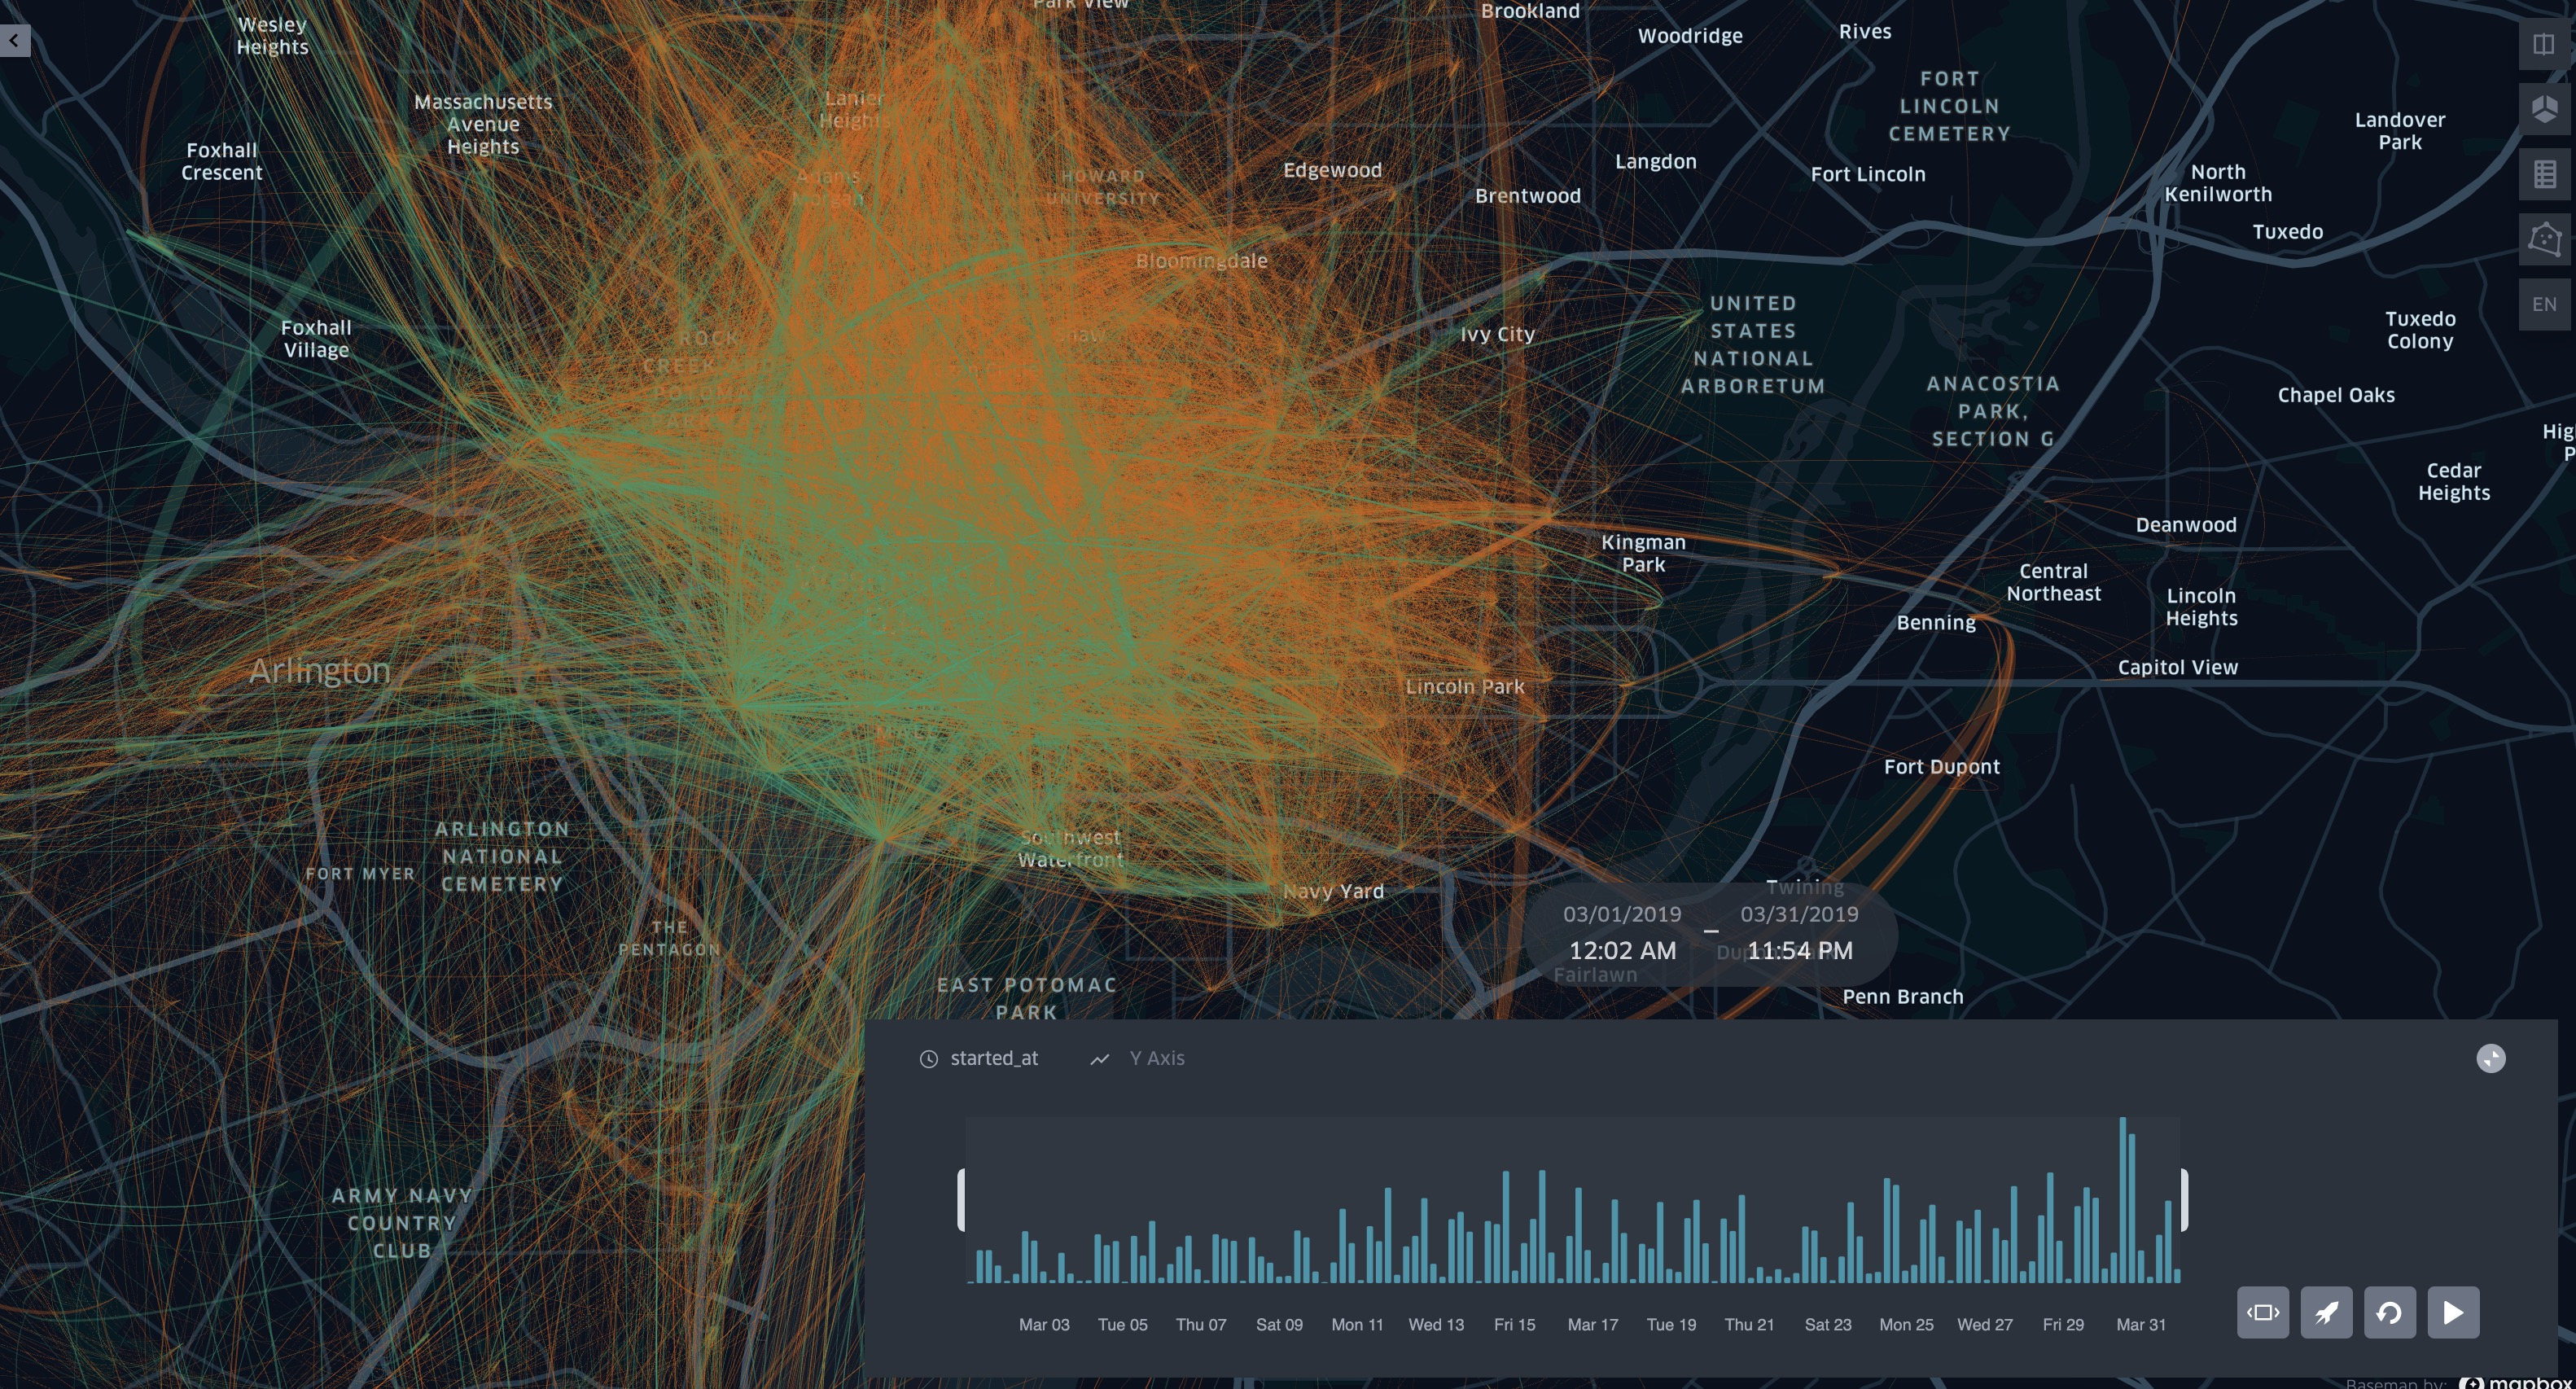

In [51]:
image_2019 = Image(filename = "Mar2019.png", width = 1000)
display(image_2019)

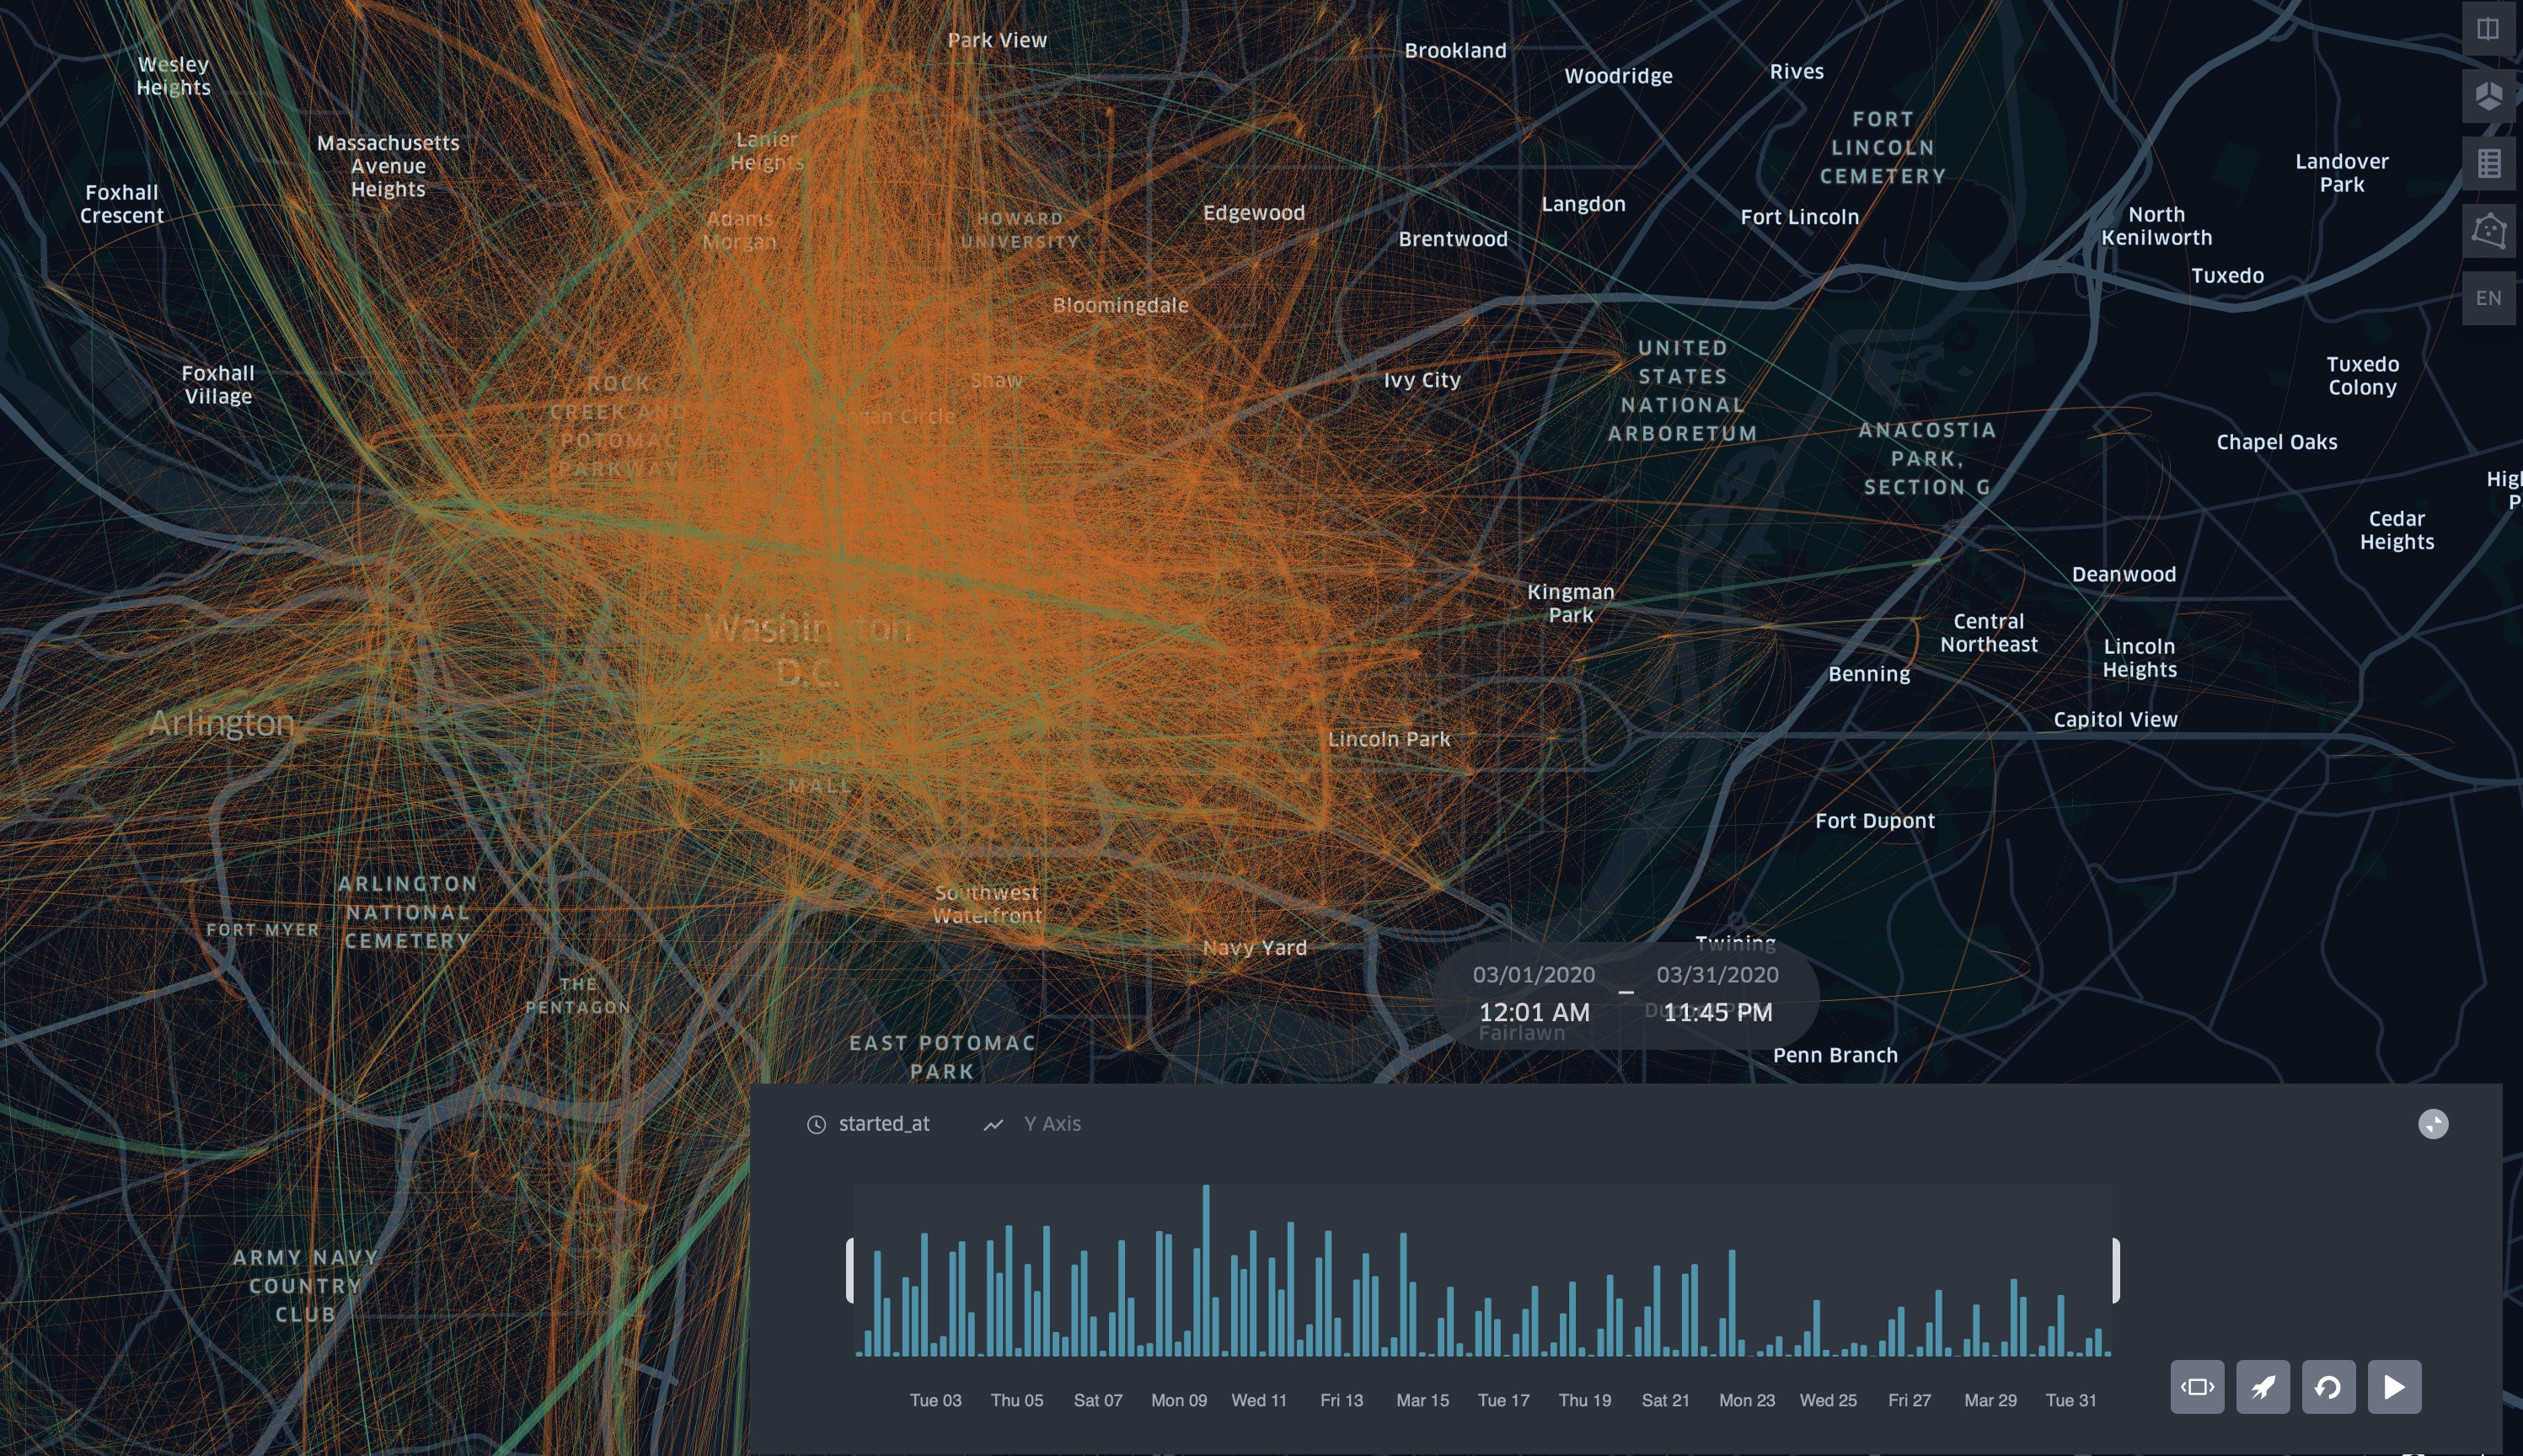

In [52]:
image_2020 = Image(filename = "Mar2020.png", width = 1000)
display(image_2020)

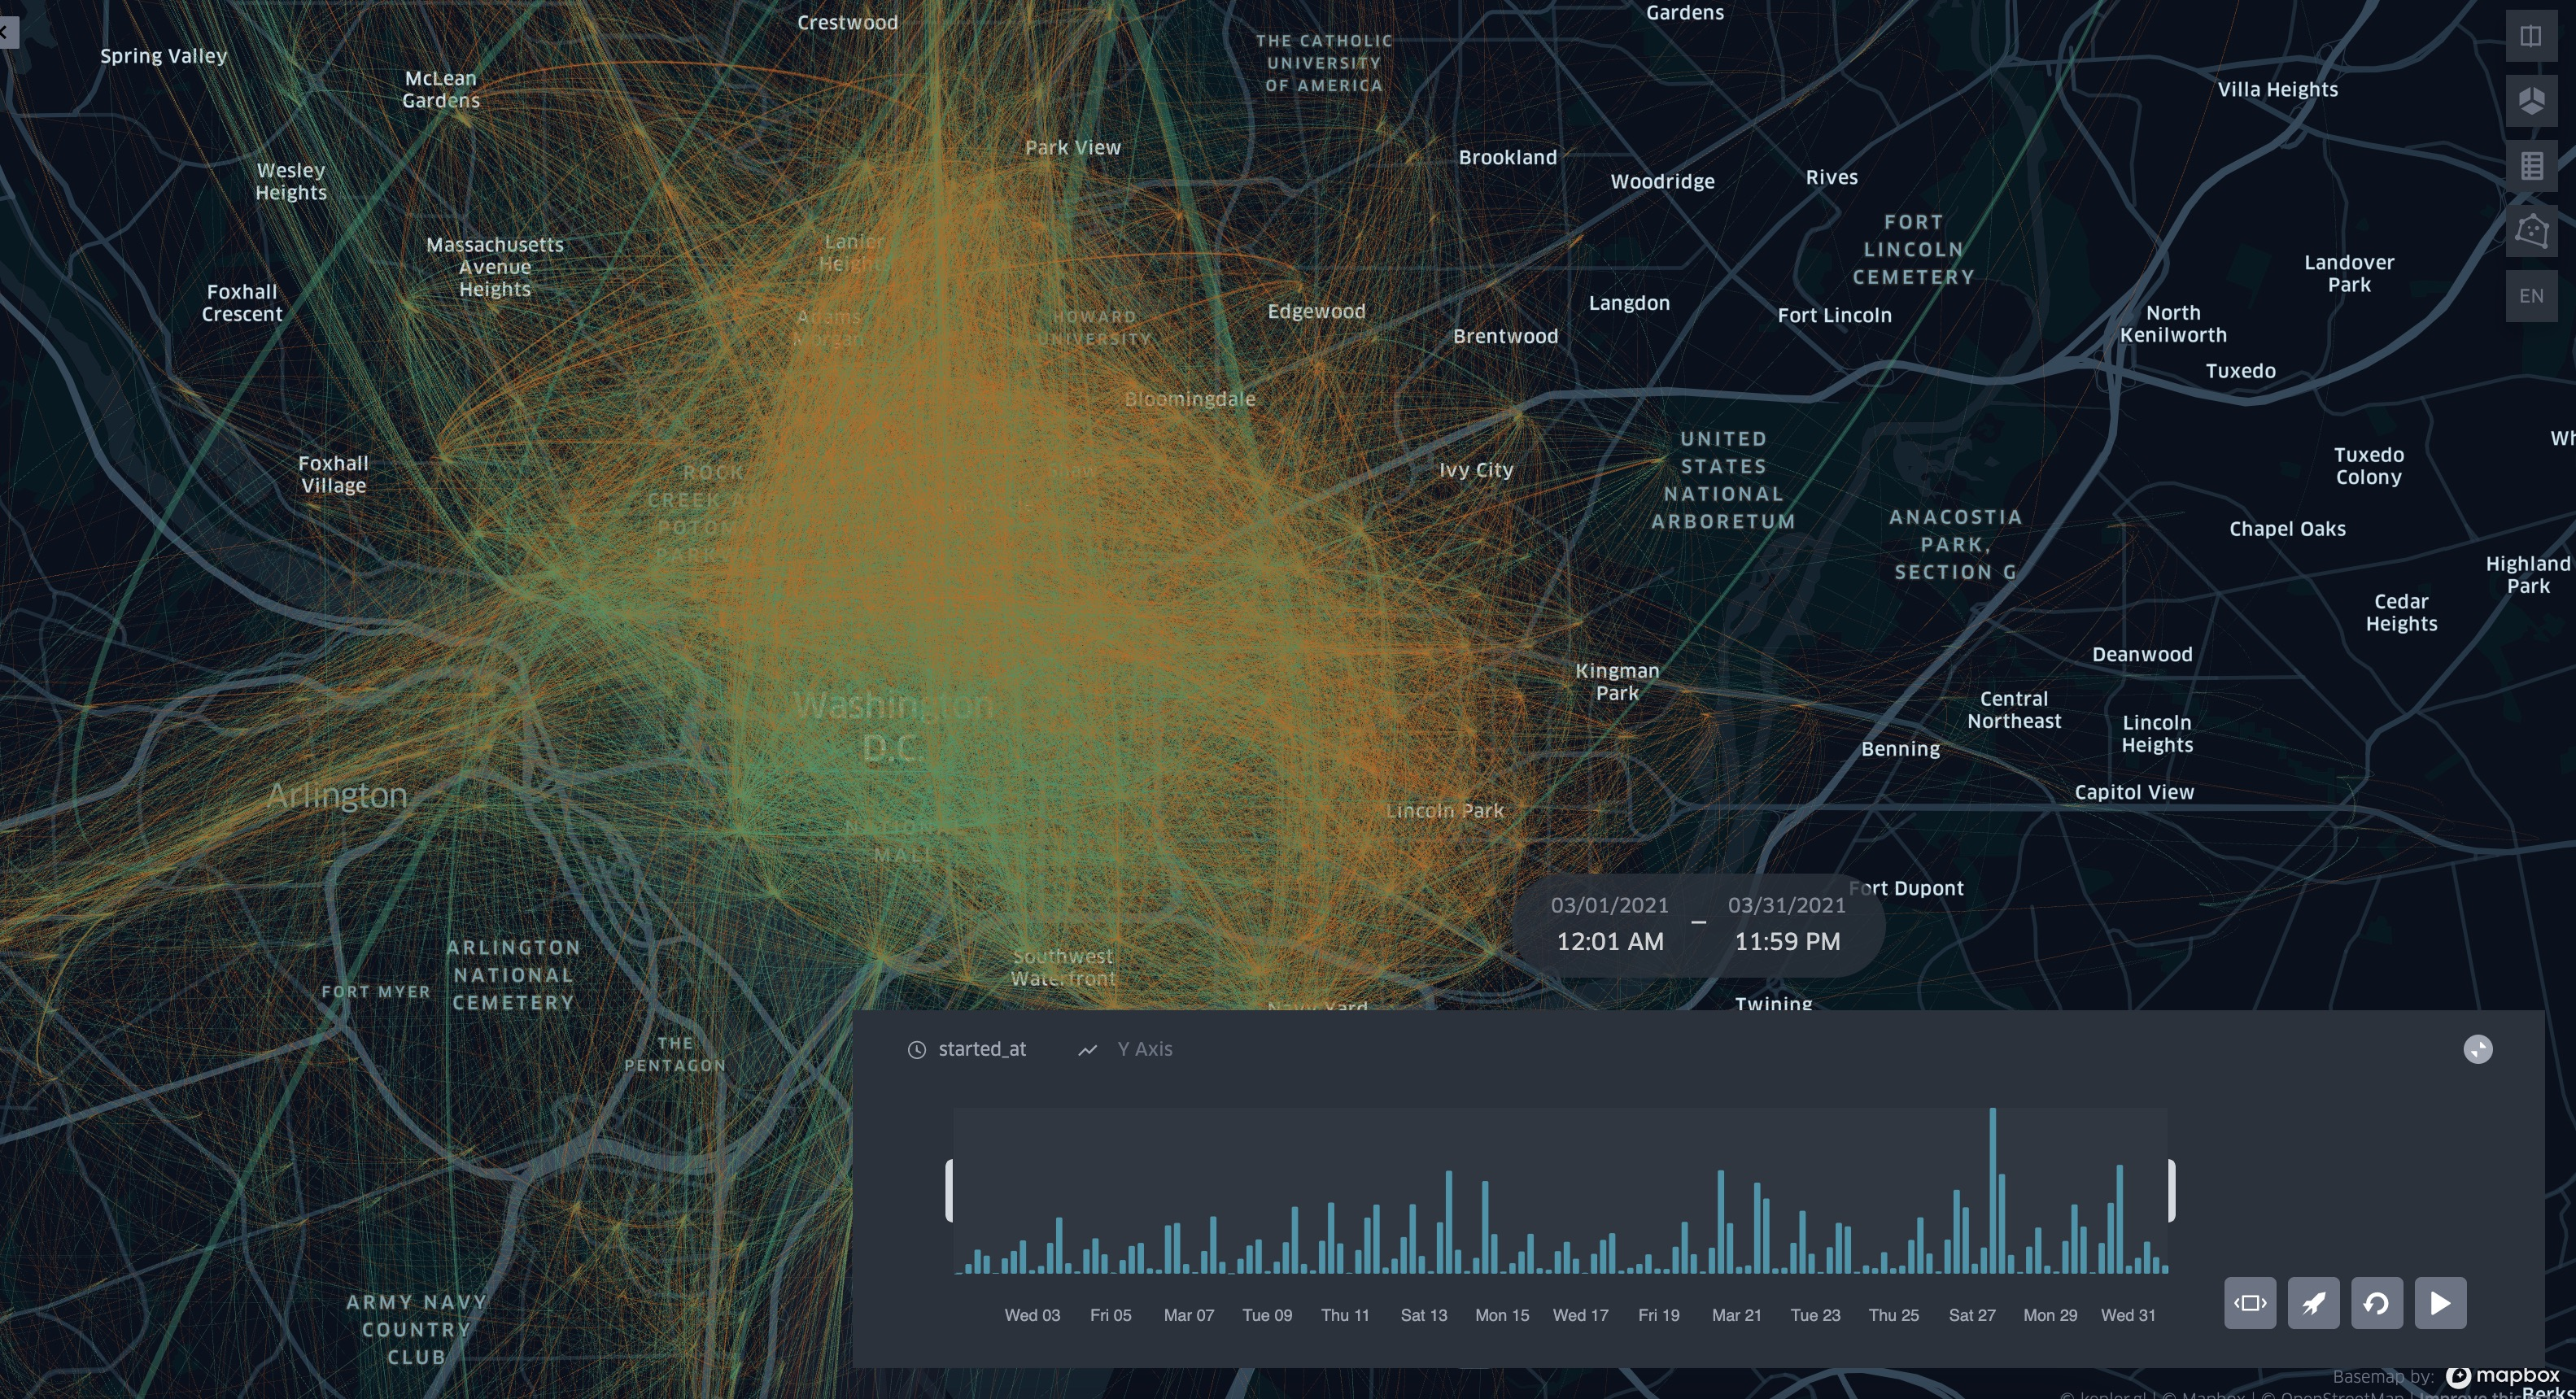

In [53]:
image_2021 = Image(filename = "Mar2021.png", width = 1000)
display(image_2021)

# Next Steps

#### 1.	Combine more datasets such as weather to explore seasonality, and predict people’s habits of using sharing bikes after the pandemic 
#### 2.	Find the popular stations and the number of bikes needed, decide allocation of bikes in those stations 
#### 3.	Merge with census data like income, public health data (obesity) to explore more trends